__Collecting Library Version info in case of deprecation:__<br>
!pip freeze > requirements

__Installing Library Version in case of deprecation:__<br>
!pip install -r requirements-March-2019.txt<br>

<div style="background-color:rgba(240,248,255, 0.5); text-align:left; vertical-align: middle;padding: 5 5">**RESOURCES:**<br>
1. [Example Blog Style Post](https://kennfucius.github.io/0001-trimet-delays/)<br>
2. [Official Data Set Link](https://research.google.com/youtube8m/)<br>
3. [Official Repo](https://github.com/google/youtube-8m)<br>
4. [Starter Kernel](https://www.kaggle.com/juliaelliott/starter-kernel-yt8m-2018-sample-data)<br>
5. [Neat Graphviz Tutorial](https://stackoverflow.com/questions/41942109/plotting-the-digraph-with-graphviz-in-python-from-dot-file)<br>
6. [TF Datatype Deprecation](https://www.tensorflow.org/guide/datasets)<br><br>

**TODO:** <br>
1. Explore the relationship between annotations and mean_audio
2. [Download](https://www.kaggle.com/krharps/download-training-videos-for-windows/) main data locally<br>
3. Remove videos that do not include any of the labels from the top 10 labels<br>
4. Upload CSV list with the remaining values<br>
5. Feature importance<br>
6. Explore how to make predictions for GAP metric<br><br>

**COMPLETED:** <br>
1. Imported data (csv and tfrecord)<br>
2. Cleaned the data (needs recheck)<br>
3. Barcharts of Labeled data<br>
4. Kernel EDA Introduction 1st draft (Hypothesis, methodology, goals, dataset info)<br>
5. Basic NetworkX Visualization<br>
6. Explore audio and rgb features (statistical inference/normalization method)<br>
7. Check again to make sure data is clean<br>
8. Explore audio and rgb features (statistical inference/normalization method <br>
9. Improve NetworkX visualization<br>
10. Fixed Tensforflow Update related bugs<br>
11. Improved YouTube Display feature<br>
12. Finished T-SNE Visualization and found outliers</div>

# __Exploratory Data Analysis:__  [YouTube-8M](https://www.kaggle.com/c/youtube8m-2018)

__This Project:__ <br>The purpose of this project is to show the benefits of EDA by uncovering latent information in this YouTube data set. This project does not focus on building a model, but instead explores ways that EDA can help us decide how to work with the data before the data reaches the model.<br><br>

__Table of Contents:__
1. [Background](#s1)
2. [Setup](#s2)
3. [CSV Files](#s3)
4. [tfRecord Files](#s4)
5. [Categorical Data](#s5)
6. [Statistical Inference](#s6)
7. [Conclusion](#s7)

<a id='s1'></a>

## 1. Background

**Competition Objective: **Learning video representation under budget constraints<br><br>
**Hypothesis:** Initial features for mean_rgb and mean_audio provide more information than later features.<br><br>
**Methodology:** Explore the relationship between labels, mean_rgb features using sample distributions and statistical tests<br><br>
**Goal:** Models can focus on a subset of features to greatly reduce processing time with a much less significant loss in prediction accuracy.<br><br>
**Data:** "Precomputed audio-visual features from billions of frames and audio segments" (i.e. anonymized):

 <div style="background-color:rgba(240,248,255, 0.5); text-align:left; vertical-align: middle;padding: 5 5"> <br>
> __label_names_2018.csv__
> * `Label_Id`: ID is used for reference and embedding
> * `Label_Name`: The labels used to represent each movie<br>
> 
> __vocabulary.csv__
> * `Index`: ID is used for reference and embedding
> * `TrainVideoCount`: Total number of videos with corresponding label
> * `KnowledgeGraphId`: Unique Link ID
> * `Name`: Names used to represent each movie
> * `WikiUrl`: Links for label to Wiki page.
> * `Vertical1`: First category label
> * `Vertical2`: Second category label
> * `Vertical3`: Third category label
> * `WikiDescription`: Initial information on Wiki page.<br>
> 
> __sample_submission.csv__
> * `VideoId`: Indexable ID 
> * `LabelConfidencePairs`: Pair (label, probability) of N predictions <br>
> 
> __train01.tfrecord__
> * `VideoId`: Indexable ID 
> * `LabelConfidencePairs`: Pair (label, probability) of N predictions
> 
> __train02.tfrecord__
> * `VideoId`: Indexable ID 
> * `LabelConfidencePairs`: Pair (label, probability) of N predictions
<br>
</div>
<br>
**Scoring Metric**: 

<br>
The model for this competition will output a list of predictions with a length equal to the number of possible YouTube labels. Each member in the list will include the ID label number and a probability distribution of all labels in the data set. GAP will be used to give a score to the predictions based on this output.<br>$$GAP = \sum_{i=1}^N p(i) \Delta r(i)$$

`N`: # label predictions (if there are 20 possible labels, N = 20)<br>
`p(i)`: $Precision = TP/TP+FP$ <br>
`r(i)`: $Recall = TP/TP+FN$<br>

<img src="https://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png" alt="Recall and Precision" style="width: 400px;">
<br>


__[What is EDA?](https://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm)__<br>
> Exploratory Data Analysis (EDA) is an essential step in any data science project. The typical steps in EDA are:
> 1. Uncover underlying structure<br>
> 2. Extract important variables<br>
> 4. Detect outliers and anomalies<br>
> 5. Test underlying assumptions about the data<br>
> 6. Decide on most appropriate models<br>
> 7. Determine optimal hyper parameter settings

<a id='s2'></a>

## 2. Setup

In [1]:
import requests                            # internet access
import urllib                              # url contact for youtube
import os                                  # navigate kaggle folder
from glob import glob                      # easy file path access
import scipy                               # general statistics
import statsmodels                         # specialized statistics
from sklearn.manifold import TSNE          # data science dim reduction for viz
import numpy as np                         # matrix and vector math
from random import randint                 # random int values for eda
import pandas as pd                        # data exploration and dataframes
import seaborn as sns                      # nice data visualization tools
import matplotlib                          # output customization
import matplotlib.pyplot as plt            # plot customization
from PIL import Image                      # img manipulation tool
import networkx as nx                      # Network/Graph plotting
from IPython.display import YouTubeVideo   # YouTube viz tool
import warnings                            # Handle and hide warnings
warnings.filterwarnings('ignore')          #
import tensorflow as tf                    # Import and run tf session
# tf.enable_eager_execution()   
tf.Session()
             #
color_choice = "cool"                      # customize colors: cool, Paired,GnBu_r
cmap = matplotlib.cm.get_cmap(color_choice)#

In [2]:
# Setup Folder/File paths
path,v_path,f_path = "../input/","video-sample/video/","frame-sample/frame/"
p_labels = path+'label_names_2018.csv'
p_vocab = path+'vocabulary.csv'
p_test = path+'sample_submission.csv'
train = ['train00.tfrecord', 'train01.tfrecord']
train_video,train_frame = [path+v_path+i for i in train], [path+f_path+i for i in train]

<a id='s3'></a>

# 3. CSV Files

CSV files are one of many different methods for storing data. CSV files are basically just rows of data with columns delineated by some marking character (most often commas). There are three CSV files that are provided in the data set. To better understand the project, each CSV needs to be examined in order to understand what data is available and to better see how all of the data relates to each other. Furthermore, data needs to be checked for errors, null values, and/or any other misleading data that might negatively affect the development of the model.

In [3]:
cols = ['label_id','label_name','misc']
df_labels = pd.read_csv(p_labels,engine='python', error_bad_lines=False)
df_vocab = pd.read_csv(p_vocab)
print(f"Label Count: {len(df_labels)} Imported Labels and 6 Errored Labels")

Label Count: 3856 Imported Labels and 6 Errored Labels


Skipping line 273: Expected 2 fields in line 273, saw 3
Skipping line 1985: Expected 2 fields in line 1985, saw 3
Skipping line 3069: Expected 2 fields in line 3069, saw 3
Skipping line 3174: Expected 2 fields in line 3174, saw 3
Skipping line 3661: Expected 2 fields in line 3661, saw 3
Skipping line 3856: Expected 2 fields in line 3856, saw 3


The table blow shows the format of the label_id file:

In [4]:
df_labels.head(5)

,label_id,label_name
0,0,Game
1,1,Video game
2,2,Vehicle
3,3,Concert
4,4,Musician


Even though we were able to import the data, there were six import errors for `df_labels`. The error `Expected 2 fields in line 273, saw 3` implies that row 273 had more than 2 delimiters (in this case 'commas'). The error lines are likely a result of commas embedded inside these labels. <br><br>__Questions:__<br>How did other teams handle this error? Why is this problem not mentioned in other EDA projects? Did users find a solution to the error or did they decide to skip over these six rows? Was the data file updated after the competition finished last year and is file is only problematic now? 

In [5]:
import csv
final_error = []

with open(p_labels) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
           #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            if len(row) == 2:
               #print(f'{row[0]}: {row[1]}')
                pass
            else:
               #print(f'{row[0]}: {row[1]},{row[2]}')
                final_error.append(row)
            line_count += 1
     #print(f'Processed {line_count} lines.')
    [print(i) for i in final_error];

['271', 'Nike', ' Inc.']
['1979', 'Space Marines (Warhammer 40', '000)']
['3165', 'Warhammer 40', '000: Dawn of War']
['3248', 'Ork (Warhammer 40', '000)']
['3766', 'Warhammer 40', '000: Dawn of War II']
['3759', 'Eldar (Warhammer 40', '000)']


After looking through the error data, it is easy to see what happened. The comma in `Warhammer 40,000` and in `Nike, Inc` acted as a delimiter and forced the code to read those rows as having 3 columns instead of 2. There might be a few approaches to solving this problem, but similar kernels did not appear to address this issue.

Now let's look at the vocab file:

In [6]:
# looking at vocab_df structure
df_vocab.sort_values(['TrainVideoCount'],ascending=False)
print(f"# of Labels: {len(df_vocab)}")
df_vocab.head(3)

# of Labels: 3862


,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,0,788288,/m/03bt1gh,Game,https://en.wikipedia.org/wiki/Game,Games,NaN,NaN,"A game is structured form of play, usually und..."
1,1,539945,/m/01mw1,Video game,https://en.wikipedia.org/wiki/Video_game,Games,NaN,NaN,A video game is an electronic game that involv...
2,2,415890,/m/07yv9,Vehicle,https://en.wikipedia.org/wiki/Vehicle,Autos & Vehicles,NaN,NaN,A vehicle is a mobile machine that transports ...


`df_vocab` appears to have more information than `df_labels`. The `KnowledgeGraphId` column appears to be a unique YouTube identifier key that pairs with the `Name` column.<br><br>

`Vertical 1`, `Vertical 2` ,and `Vertical 3` are three columns of categories that the `Name` column is considered to be a member of. For example, the values <span style="color:darkblue">Game</span>  and <span style="color:darkblue">Video game</span> in the `Name` column  both have the value of <span style="color:darkblue">Games</span>  in the `Vertical 1` column.

The information above is fairly straightforward, but there is also some continuous data under the `TrainVideoCount`column. This is a good feature to try and visualize with bar plots:

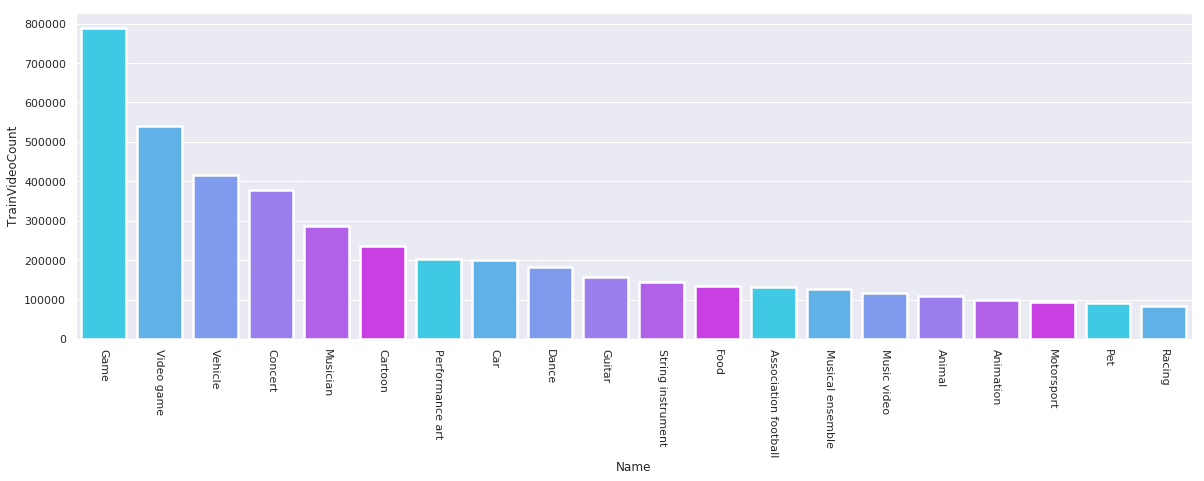

In [7]:
sns.set(rc={'figure.figsize':(20,6)})
g=sns.barplot(data=df_vocab.iloc[0:20],x='Name',y='TrainVideoCount',palette=sns.color_palette(color_choice),linewidth=2.5)
g.set_xticklabels(df_vocab['Name'].iloc[0:50].values,rotation=-90);

In [8]:
# Check unique vals for categoricals
print('Number of Unique Labels for "Name": ',len(df_vocab.Name.unique()))
print('Number of Unique Labels for "Vertical1": ',len(df_vocab.Vertical1.unique()))
print('Number of Unique Labels for "Vertical2": ',len(df_vocab.Vertical2.unique()))
print('Number of Unique Labels for "Vertical3": ',len(df_vocab.Vertical3.unique()))

Number of Unique Labels for "Name":  3807
Number of Unique Labels for "Vertical1":  25
Number of Unique Labels for "Vertical2":  22
Number of Unique Labels for "Vertical3":  15


The number of unique values decreases from `Name` to `Vertical3`. It is unclear what Vertical means, but there does appear to be a decrease in the number of unique categories from `Vertical1` to `Vertical3`. My initial thought would be that these verticals represent the 2nd, 3rd, and 4th possible major categories for a video.

Let's visualize the `Vertical` columns to see if any other trends emerge:

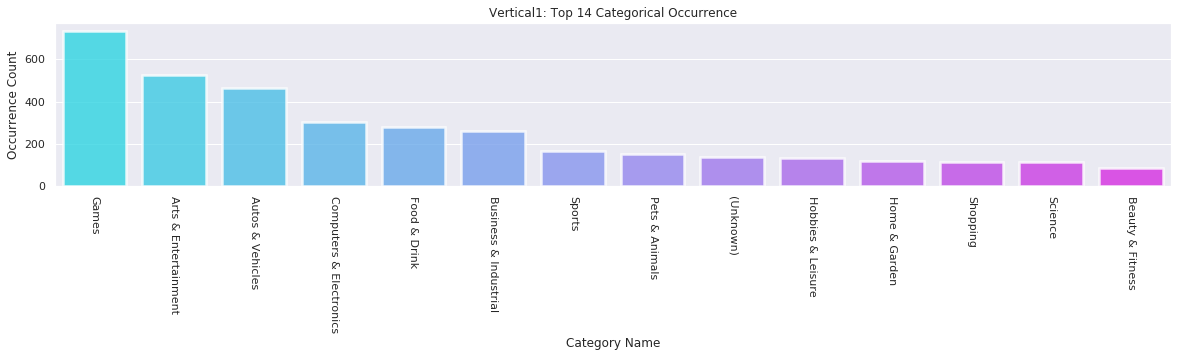

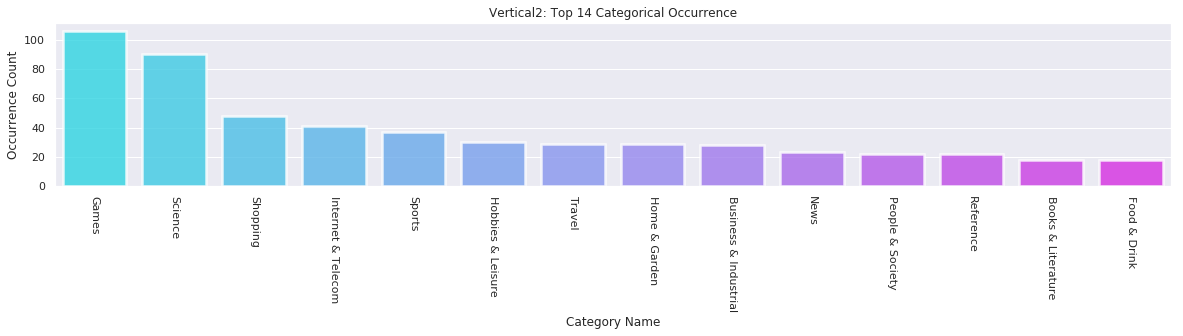

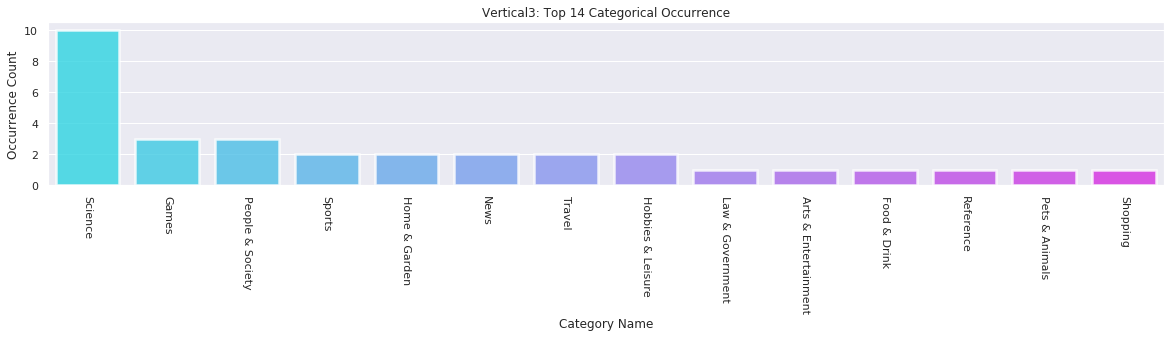

In [9]:
# assign limit and columns for barplot
top_n = 14
v_names = ['Vertical1','Vertical2','Vertical3']

# loop to visualize each column with the same params
for v in v_names:
    v_counts  = df_vocab[v].value_counts()[:top_n,]
    plt.figure(figsize=(20,3))
    g = sns.barplot(v_counts.index, 
                    v_counts.values, 
                    alpha=0.8, 
                    palette=color_choice,
                    linewidth=2.5)
    g.set_xticklabels(v_counts.index,rotation=-90);
    plt.title(f'{v}: Top {top_n} Categorical Occurrence')
    plt.ylabel('Occurrence Count', fontsize=12)
    plt.xlabel('Category Name', fontsize=12)
    plt.show()

Looking at the bar charts above, it is apparent that <span style="color:darkblue">Games</span> is a clear leader in all three plots, <span style="color:darkblue">Sports</span> comes in second, and <span style="color:darkblue">Science</span> appears to appear most frequently in `Vertical2` and `Vertical3`.

Finally, let's look at the example predictions csv file:

In [10]:
df_sub = pd.read_csv(p_test); df_sub.head(3)

,VideoId,LabelConfidencePairs
0,000c,1 0.5 2 0.3 3 0.1 4 0.05 5 0.05
1,000x,1 0.5 2 0.3 3 0.1 4 0.05 5 0.05
2,001N,1 0.5 2 0.3 3 0.1 4 0.05 5 0.05


`Video Id` appears to hold the video index namefrom the tf data that we will look at next. The `LabelConfidencePairs` are a little harder to decipher. For example, index 0 has a set of predictions  `[1 0.0] [2 0.3][3 0.2]...`  The first value represents the guess for the label and the second value represents the probability of that label given the probability of it being other labels.

<a id='s4'></a>

## 4. tfRecord Files

Tensorflow uses tfRecord files to store data in binary string format. Binary strings are very efficient with regards to big data because binary data takes up less physical space. tfRecord files can also be accessed in batch format, which is helpful in cases where memory is an issue. Considering that the full size of the data set is approximately 14 Tb, it's easy to understand the need for tfRecord files. In this situation, we will iterate through the example tfrecord files to understand the data structure and to run some basic analyses.

In [11]:
v_vid_ids,v_labels,v_mean_rgb,v_mean_audio = [],[],[],[]

for train_v in tf.python_io.tf_record_iterator(train_video[0]):
    tf_v= tf.train.Example.FromString(train_v)
    v_vid_ids.append(tf_v.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
    v_labels.append(tf_v.features.feature['labels'].int64_list.value)
    v_mean_rgb.append(tf_v.features.feature['mean_rgb'].float_list.value)
    v_mean_audio.append(tf_v.features.feature['mean_audio'].float_list.value)
print(f'train00.tfrecord video count: {len(v_mean_rgb)}')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
train00.tfrecord video count: 1015


Now that we have captured the data. Lets take a quick look at the dimensions of some of the values we captured:

YouTube id: fw00
fw00 has 1024 v_mean_rgb vals.
fw00 has 128 v_mean_audio vals.
fw00 has 1 v_label vals. # varies from video to video


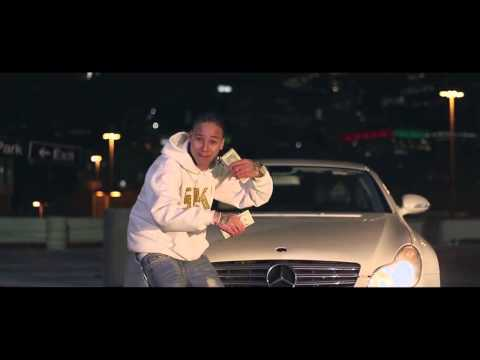

In [12]:
r_i = randint(0,len(v_mean_rgb))
print(f'YouTube id: {v_vid_ids[r_i]}')
print(f'{v_vid_ids[r_i]} has {len(v_mean_rgb[r_i])} v_mean_rgb vals.')
print(f'{v_vid_ids[r_i]} has {len(v_mean_audio[r_i])} v_mean_audio vals.')
print(f'{v_vid_ids[r_i]} has {len(v_labels[r_i])} v_label vals. # varies from video to video')
url_id = f"http://data.yt8m.org/2/j/i/{v_vid_ids[r_i][0:2]}/{v_vid_ids[r_i]}.js"
f = urllib.request.urlopen(url_id)
key = f.read().decode("utf-8")[10:-3]
vid = YouTubeVideo(key,width=300, height=200)
display(vid)

All of the `mean_rgb` values and `mean_audio` values are a result of data pulled from videos like the one shown above. It is unclear how the `mean_rgb` and `mean_audio` values were derived, but it is likely that there will be some differences in these values based on the type of video.

[Julia Elliot](https://www.kaggle.com/juliaelliott/starter-kernel-yt8m-2018-sample-data): 
> As described on the YouTube8M download page, for privacy reasons, the video id has been randomly generated and does not directly correspond to the actual YouTube video id. To convert the id into the actua YouTube video id, we follow link: http://data.yt8m.org/2/j/i/1r/1r00.js

In [13]:
d = pd.DataFrame(data=v_mean_rgb)
corr_all = d.corr()
corr_all.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.000000,-0.052172,-0.024176,-0.024619,-0.240410,-0.244139,0.006879,-0.084385,0.031035,0.050992,0.026283,-0.072185,-0.027575,-0.016816,0.101561,-0.016037,0.026146,0.017934,0.034705,-0.022551,0.012941,0.096802,0.077840,0.051744,0.010277,-0.065306,-0.041454,0.048330,-0.097211,0.053065,-0.100570,0.035786,-0.102345,-0.041330,0.093065,-0.099493,0.028640,-0.029753,-0.000242,-0.001884,...,0.029726,-0.027025,-0.003710,-0.001053,0.020230,0.010717,-0.001939,0.012578,-0.007952,-0.012820,-0.024903,-0.005523,-0.034855,0.022121,-0.029707,-0.025132,-0.037304,-0.015155,-0.008942,0.008288,-0.042576,-0.068764,0.008154,-0.086701,-0.008323,-0.020394,-0.018998,0.015807,0.012754,0.053526,-0.022940,0.030484,0.011066,-0.008444,-0.034370,-0.037358,-0.022839,0.042876,0.020418,-0.100664
1,-0.052172,1.000000,0.015463,-0.084140,-0.145714,0.077545,0.039018,0.139440,-0.060530,-0.001405,0.097446,-0.022813,-0.037377,-0.001830,0.048623,0.125084,0.060342,-0.006655,-0.027161,0.034375,-0.008356,-0.141592,-0.094412,0.024466,-0.101698,0.062277,0.019509,-0.031789,0.000442,-0.035826,-0.000229,-0.031368,0.048748,0.002921,-0.017297,-0.093505,0.062760,-0.003160,0.033139,-0.028203,...,0.032588,0.054253,-0.060720,-0.021160,-0.039699,0.009459,0.031942,-0.018800,-0.008595,0.019356,0.037045,-0.010018,-0.035847,-0.008280,-0.044951,0.005096,-0.078290,0.015423,0.017170,0.029735,-0.015199,-0.005525,-0.019924,0.031597,-0.016492,0.013330,0.071066,0.025117,0.014191,0.005197,0.010940,0.048624,0.069684,0.016983,0.001624,-0.019016,0.002736,-0.096957,-0.079349,-0.000890
2,-0.024176,0.015463,1.000000,-0.049129,0.020121,-0.003853,0.022471,-0.065167,-0.050948,0.028211,-0.048864,0.035483,0.078380,0.026253,-0.025027,-0.043209,-0.001971,0.035950,-0.024268,-0.056822,0.077138,-0.058770,0.073548,0.004530,-0.035774,0.040085,-0.029407,0.048292,-0.009639,0.032504,-0.002951,-0.010992,0.022661,0.004406,-0.027254,0.029189,0.010453,0.001356,0.038554,-0.005827,...,0.003083,-0.107632,-0.042138,-0.010293,-0.003025,0.018823,0.000868,0.010434,-0.071577,0.034803,-0.010309,-0.060979,0.004819,-0.048377,-0.023723,-0.037279,-0.032754,0.033511,-0.006133,-0.002075,-0.038292,0.004654,0.043480,-0.050498,0.029896,-0.015051,0.076239,0.024839,0.012367,0.064813,0.028643,0.084336,0.009952,0.020314,0.005424,-0.010047,0.057095,-0.015482,-0.046964,0.036730


In [14]:
c = 0
r = [0.2,-0.2]
for i in range(len(corr_all)):  # This is not an efficient algorithm/needs improvement
    for j in range(len(corr_all.columns)): 
        if (corr_all.iloc[i,j] >r[0]) & (corr_all.iloc[i,j]<1):
            c+=1
        elif (corr_all.iloc[i,j] <r[1]) & (corr_all.iloc[i,j]<1):
            c+=1
print(f"There are 0 values with a correlation greater than 0.3 and/or less than -0.3")
print(f"There are {c} values with a correllation greater than {r[0]} and/or less than {r[1]}")

There are 0 values with a correlation greater than 0.3 and/or less than -0.3
There are 10 values with a correllation greater than 0.2 and/or less than -0.2


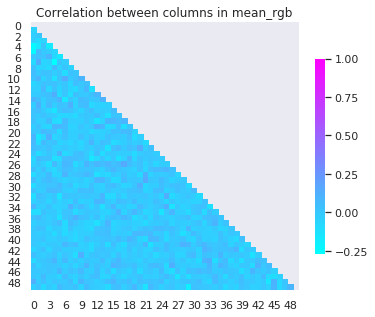

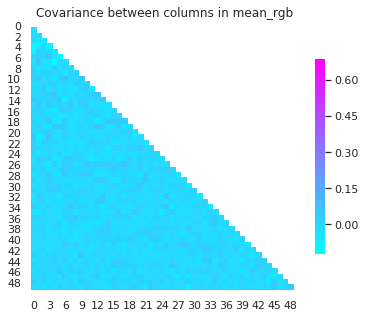

In [15]:
first_100 = [i[0:50] for i in v_mean_rgb]
d = pd.DataFrame(data=first_100)
corr = d.corr()

mask = np.zeros_like(corr, dtype=np.bool) # I'm not sure I understand this approach
mask[np.triu_indices_from(mask)] = True   #

f, ax = plt.subplots(figsize=(6, 6))
sns.set_style('whitegrid')
sns.heatmap(corr, mask=mask, cmap=color_choice, cbar_kws={"shrink": .6}, square=True,)
plt.title('Correlation between columns in mean_rgb')
plt.show()

first_100 = [i[0:50] for i in v_mean_rgb]
d = pd.DataFrame(data=first_100)
corr = d.cov()

mask = np.zeros_like(corr, dtype=np.bool) # I'm not sure I understand this approach
mask[np.triu_indices_from(mask)] = True   #

f, ax = plt.subplots(figsize=(6, 6))
sns.set_style('whitegrid')
sns.heatmap(corr, mask=mask, cmap=color_choice, cbar_kws={"shrink": .6}, square=True,)
plt.title('Covariance between columns in mean_rgb')
plt.show()

Looking at example correlation and covariance plots, we can see that there is little linear relationship between different features in the `mean_rgb` df (and this is likely the same for the `mean_audio` df). I suspect that the data is already gona through some transformations like SVD or PCA to simplif and normalize the data.

In [16]:
# Repeat the loading process for the train_frame section:
f_vid_ids,f_labels,f_rgb,f_audio = [],[],[],[]

for train_f in tf.python_io.tf_record_iterator(train_frame[0]):
    train_f= tf.train.Example.FromString(train_f)
    f_vid_ids.append(train_f.features.feature['id'])
    f_labels.append(train_f.features.feature['labels'].int64_list.value)
    f_rgb.append(train_f.features.feature['rgb'].float_list.value)
    f_audio.append(train_f.features.feature['audio'].float_list.value)
    
print(f"f_audio: {[i for i in f_audio if len(i)>0]}, f_rgb: {[i for i in f_rgb if len(i)>0]}")

f_audio: [], f_rgb: []


The `train_frame` tfRecord audio and rgb values lists are empty. Why do we even have this file and what exactly is a frame?

<a id='s5'></a>

## __5. Categorical Data__

### __A. NetworkX__

NetworkX is a data visualization tool in Python that utilizes Social Network theory to visualize and/or calculate relationships between categorical. Graphing networks really only works in situations where categorical data appears next to each othereither a sequential fashion or a grouping fashion. In this case, YouTube videos appear to have multiple labels per video, so a network graph is very relevant. By using NetworkX we can confirm whether or not the labels in the YouTube data set have a meaningful relationship (i.e. to topics tend to cluster), and we can see which labels are more central/more distant in the network graphs.

__How it works__: Networks are built from a collection of edges and nodes. In this project, each unique label is represented by a node and edges between these nodes represent any co-occurrence of labels in a YouTube video. For example, a network graph for a YouTube video with labels `Dog` and `Pets` would have two nodes (one for `Dog` and one for `Pets`) with one edge that connects the two nodes. There are numerous algorithms you can use to calculate the node/edge relationships. For non-directional graphs, clustering coeffecients and measures of centrality, and other metrics can be used to observe patterns and groupings within the network.<br><br>
__Drawbacks__: Network graphs are helpful in EDA because they are unsupervised and provide visual/technical clues to patterns in the labeled data. This helps us better understand the data we are working with. However, these graphs are less helpful when building a supervised model (in this case probably XGboost or a neural network). 

In [17]:
# writing generators for practice
def create_adjacency_matrix(vals):
    # create adjacency.txt for easy networkx import
    with open('adj.txt','w') as file:
        for l in vals:
            if len(l) > 1:
                file.write('|'.join(l)+'\n')
                
def get_label_check(it):
    yield [list(df_labels.label_name[df_labels.label_id == i].values)[0] for i in it]
    
lab = (get_label_check(label) for label in v_labels)
count = [i for it in lab for i in it]
create_adjacency_matrix(count)
G = nx.read_adjlist('adj.txt',delimiter='|')

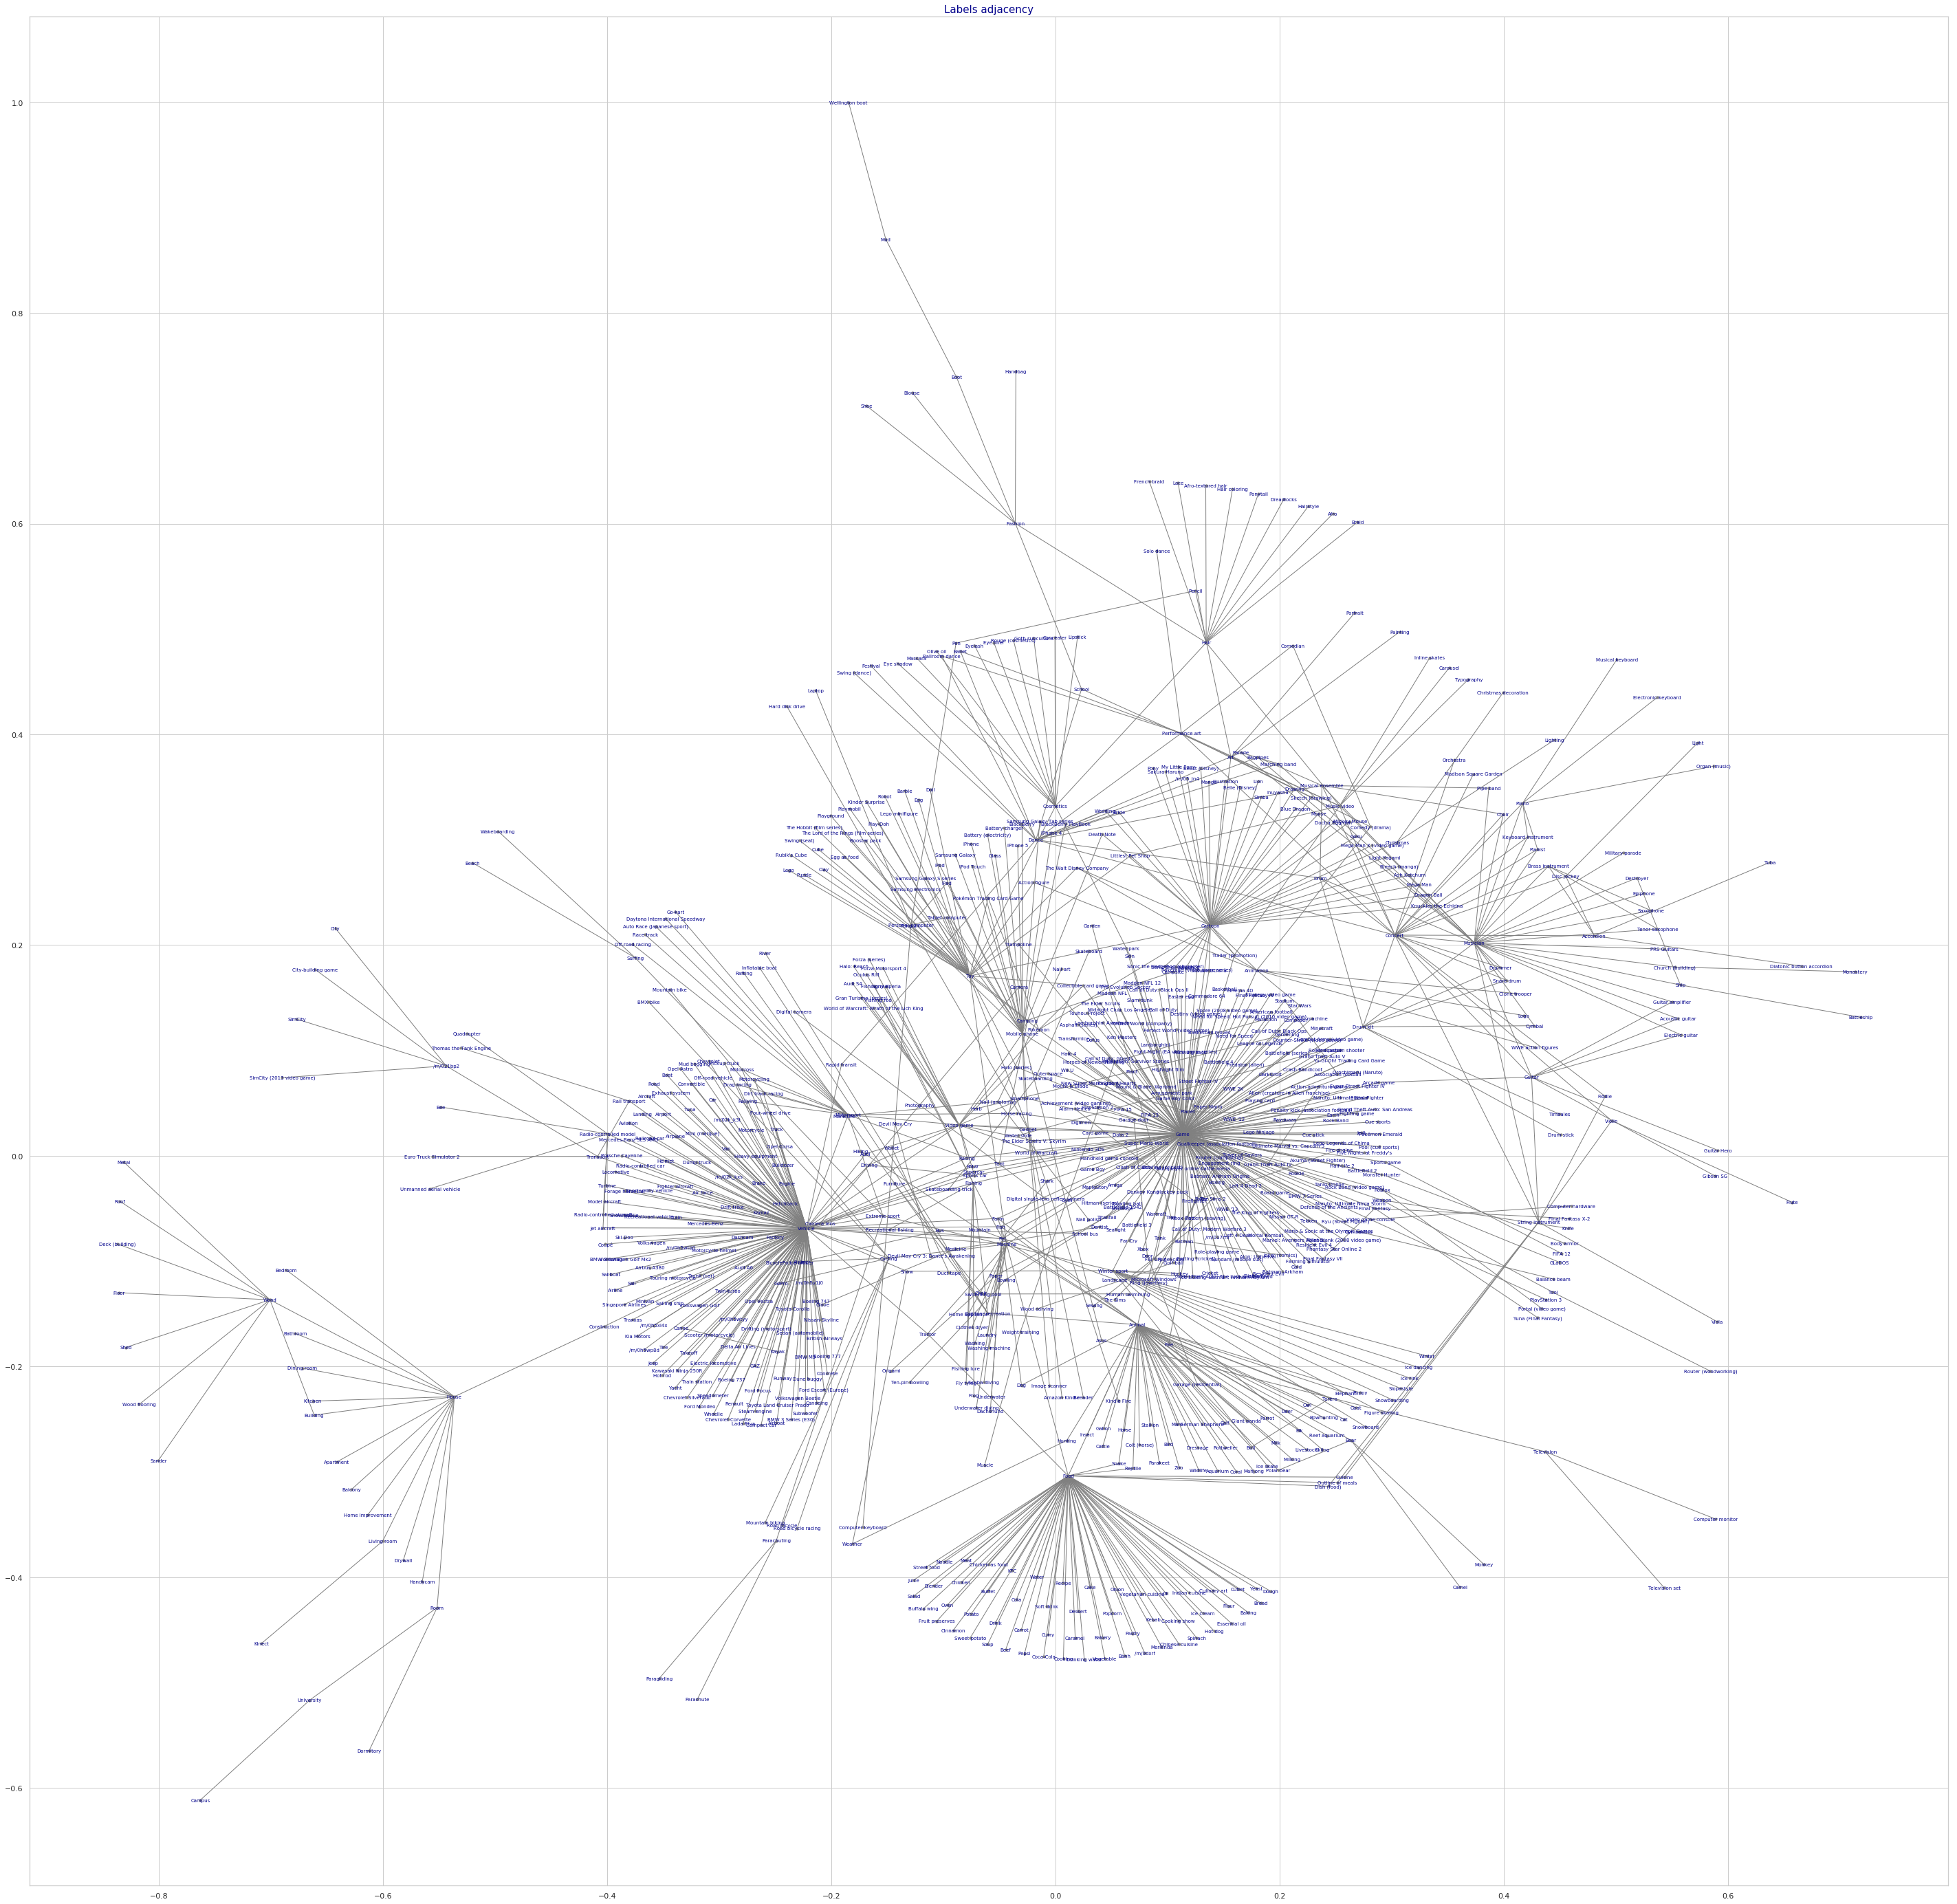

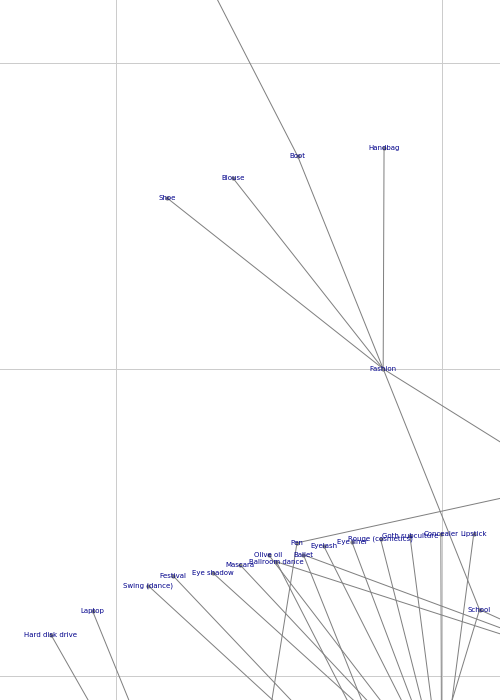

In [18]:
# %%capture
# Begin Visualization
fig = plt.figure(figsize=(50,50))
plt.title('Labels adjacency',size=15,color='darkblue')

# draw edges
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_edges(G,pos=pos, edge_color='gray')
nx.draw_networkx_nodes(G,pos=pos,node_size=10, node_color='gray')
nx.draw_networkx_labels(G,pos=pos,font_size=7,font_color='darkblue')
plt.savefig('big_network.png')
plt.show()

img = Image.open("big_network.png")
area = (1500, 800, 2000, 1500)
cropped_img = img.crop(area)
cropped_img.save('big_network_crop.png')
display(cropped_img)

### __B. T-Distributed Stochastic Neighbor Embedding (TSNE)__

Because the `mean_rgb` and `mean_audio` data have 100+ columns, it is hard to visualize the relationship between the videos and their rgb/audio data. In this case, TSNE [(source)](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) is helpful as it provides a method for reducing the data's dimensionality (i.e. number of columns) to a lower number of dimensions (in this case, 2 dimensions). By reducing dimensionality, it is possible to visualize the data on the X/Y axes (while using colors to represent video categories). <br><br>Examples of alternative methods for reducing dimensionality are RFE, PCA, and SVD. These methods, however, operate by either eliminating dimensions (removing columns) or by finding latent dimensions (removing all columns and creating a smaller subset of new columns). The goal here is simply to visualize the data so as to better understand how groups relate to each other.

__How it works:__ TSNE operates on conditional probabilities. TSNE uses the Stochastic Neighbor Embedding (SNE) method to calculate pairwise similarity from conditional probabilities derived from Euclidean distances between points. of point similarity in the original dimensions and compares the results of those probablities when mapped to lower dimensions. TSNE is similar to other ML methods in that it uses a gradient descent method with a cost function that adjusts the model until optimal values are found. T in TSNE indicates that the model is built to follow the parameters of the [Student T-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution)  (as the model operates on probability distributions)instead of the Gaussian distribution.

__Drawbacks:__ O(n^
2) complexity and non-Gaussian

In [19]:
# function to return the index of the video if it has n label
def label_indices(labels_list, i_r):
    labs = tuple(zip(df_labels['label_id'].iloc[i_r].values,
                     df_labels['label_name'].iloc[i_r].values))

    label_indices = {}
    for l in labs:
        s_l =[]
        for i,j in enumerate(labels_list):  
            if l[0] in j:
                s_l.append(i)
        label_indices[l[1]] = s_l
    return label_indices

Lets setup [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to address the problem of n dimensions being shown on a 2d graph. T-SNE attempts to reduce divergence from join probabilities of features. 

In [20]:
def tsne_reduce(X,y):
    tsne = TSNE(n_components=2, random_state=42,learning_rate=250)
    df = pd.DataFrame(tsne.fit_transform(X))
    df['y'] = y
    return df

#### A. Mean_RGB

The next step is to remove all `mean_rgb` values that don't have a label from the list of top n labels. We will use t-sne to reduce the dimensionality of the data from `1024` to `2` so that we can map the data to the `X` and `Y` axis.

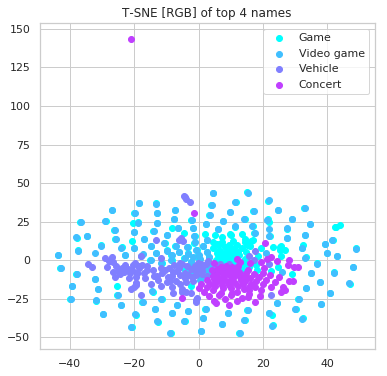

In [21]:
n_labels = 4
top_indices = label_indices(v_labels, range(0,n_labels))
top_labels = df_labels['label_name'][0:n_labels].values
top_v_mean_rgb,label_column = [], []
for k in top_indices.keys():
    [label_column.append(k) for i in top_indices[k]]
    [top_v_mean_rgb.append(v_mean_rgb[i]) for i in top_indices[k]]

df_tsne = tsne_reduce(top_v_mean_rgb,label_column)

plt.figure(figsize=(6, 6))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple'
for i, c, label in zip(range(0,n_labels),colors[0:n_labels], top_labels):
    plt.scatter(df_tsne[0][df_tsne['y']==label], 
                df_tsne[1][df_tsne['y']==label], 
                c=[cmap(i/n_labels)], 
                label=top_labels)
plt.legend(top_labels)
plt.title(f'T-SNE [RGB] of top {n_labels} names')
plt.show()

From this visualization there are clear clusters for <span style="color:darkblue">Game</span> , <span style="color:darkblue">Vehicle</span> , and <span style="color:darkblue">Concert</span> . However, <span style="color:darkblue">Video game</span>  is virtually all over the place. This might indicate that videos with the <span style="color:darkblue">Video game</span>  tag might be more difficult to identify and predict (assuming that the model accounts for this largely imbalanced data set). <br><br>

Another interesting aspect of this data set is that it shows one extreme outlier under the <span style="color:darkblue">Concert</span> category. It might be worth investigating whether or not we can find this unique concert value as watching the video with this outlier could shine some light into the background on the `mean_rgb` values.

Let's find the outlier:

In [22]:
df_tsne[df_tsne['y']=='Concert' ][df_tsne[1]>70]

,0,1,y
468,-20.917202,143.142715,Concert


And get the index from that outlier for the main list of youtube videos:

In [23]:
outlier_index = df_tsne[df_tsne['y']=='Concert'][df_tsne[1]>70].index[0]
print(f"The outlier is at index for df_tsne: {outlier_index}")
outlier_index -= df_tsne[df_tsne['y']=='Concert'].index[0]
outlier = top_indices[k][8]
print(f"The outlier is at index for v_mean_rgb: {top_indices[k][8]}")

The outlier is at index for df_tsne: 468
The outlier is at index for v_mean_rgb: 94


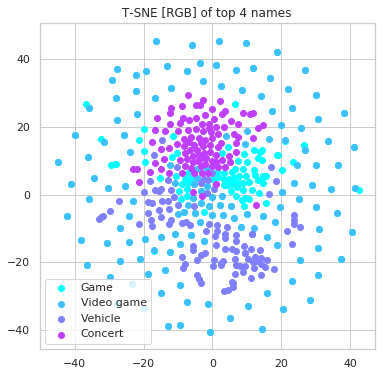

In [24]:
n_labels = 4
top_indices = label_indices(v_labels, range(0,n_labels))
top_labels = df_labels['label_name'][0:n_labels].values
top_v_mean_rgb,label_column = [], []
for k in top_indices.keys():
    [label_column.append(k) for i in top_indices[k] if i != outlier]
    [top_v_mean_rgb.append(v_mean_rgb[i]) for i in top_indices[k] if i != outlier]

df_tsne = tsne_reduce(top_v_mean_rgb,label_column)

plt.figure(figsize=(6, 6))
for i, c, label in zip(range(0,n_labels),colors[0:n_labels], top_labels):
    plt.scatter(df_tsne[0][df_tsne['y']==label], 
                df_tsne[1][df_tsne['y']==label], 
                c=[cmap(i/n_labels)], 
                label=top_labels)
plt.legend(top_labels)
plt.title(f'T-SNE [RGB] of top {n_labels} names')
plt.show()

Outlier ID: ox00


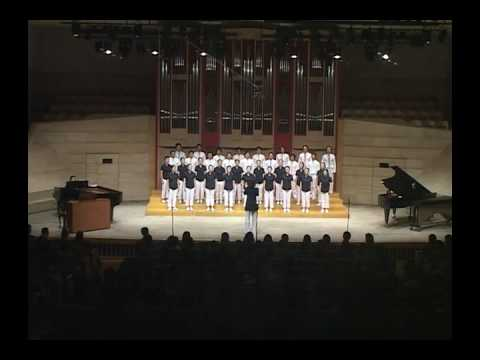

In [25]:
url_id = f"http://data.yt8m.org/2/j/i/{v_vid_ids[outlier][0:2]}/{v_vid_ids[outlier]}.js"
f = urllib.request.urlopen(url_id)
key = f.read().decode("utf-8")[10:-3]
vid = YouTubeVideo(key,width=200, height=150)
print(f'Outlier ID: {v_vid_ids[outlier]}')
display(vid)

Looking at the video, there are a lot of things that stand out. It appears that the top and bottom half of the scene is mostly black and that only the middle third portion contains content. As the video progresses, nothing in the video appears to change. The video is almost static with only small changes in movement near the center of the video. From these observations, it could be posssible that the video is an outlier because of either the black borders or because of the lack of change in the video.<br><br>
Next, let's compare this video to other categories that have a similar label so as to see if this is observed in other videos:

Normal Video ID: xg00


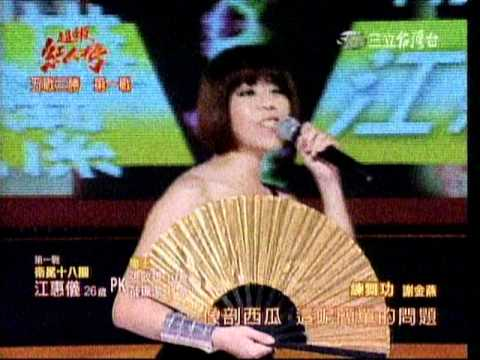

Normal Video ID: nm00


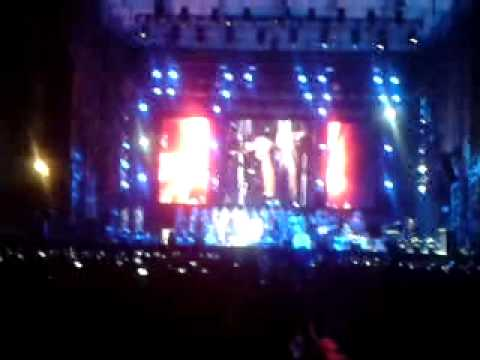

Normal Video ID: P900


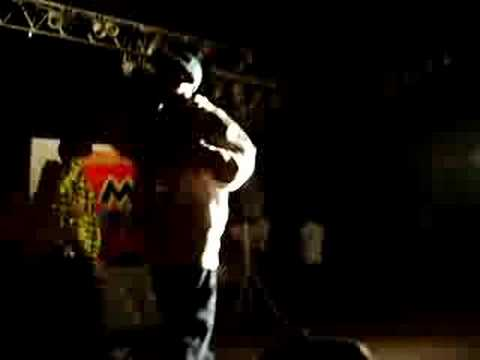

Normal Video ID: vj00


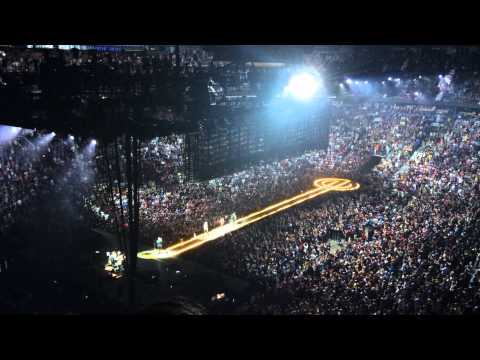

Normal Video ID: 8500


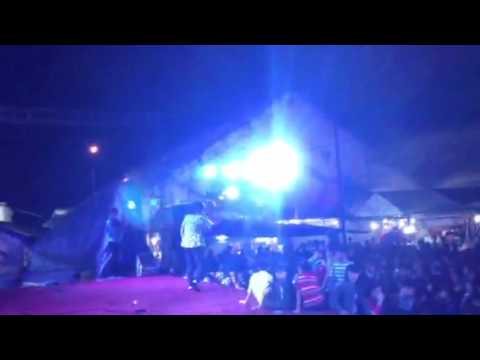

Normal Video ID: ob00


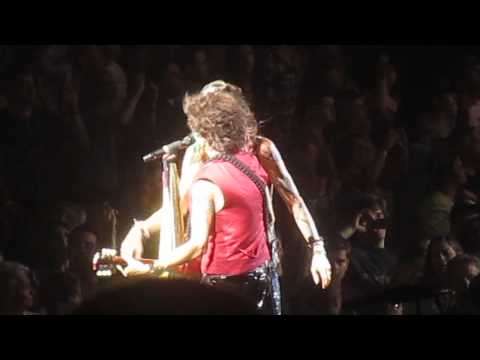

Normal Video ID: CB00


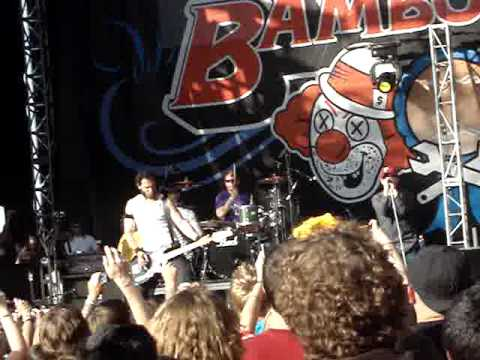

In [26]:
l_normals = [0,1,2,10,11,-3,-2,-1]
for i in l_normals:
    try:
        normal_value = v_vid_ids[top_indices['Concert'][i]]
        url_id = f"http://data.yt8m.org/2/j/i/{normal_value[0:2]}/{normal_value}.js"
        f = urllib.request.urlopen(url_id)
        key = f.read().decode("utf-8")[10:-3]
        print(f"Normal Video ID: {normal_value}")
        vid = YouTubeVideo(key,width=150, height=100)
        display(vid)
    except:
        continue

None of the example videos above exhibit the same tendencies as the first outlier video. I suspect that this might indicate that the mean_rgb values do reflect some averaging of colors based on rgb changes and/or average rgb values per pixel.

#### A. Mean_Audio

The next step is to remove all `mean_rgb` values that don't have a label from the list of top n labels. We will use t-sne to reduce the dimensionality of the data from `1024` to `2` so that we can map the data to the `X` and `Y` axis.

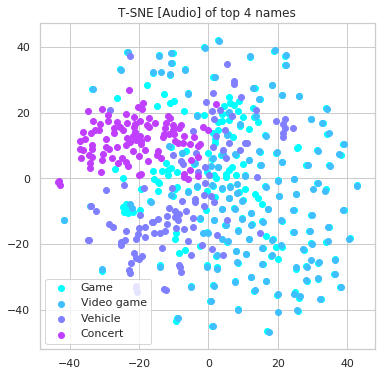

In [27]:
n_labels = 4
top_indices = label_indices(v_labels, range(0,n_labels))
top_labels = df_labels['label_name'][0:n_labels].values
top_v_mean_audio,label_column = [], []
for k in top_indices.keys():
    [label_column.append(k) for i in top_indices[k]]
    [top_v_mean_audio.append(v_mean_audio[i]) for i in top_indices[k]]

df_tsne = tsne_reduce(top_v_mean_audio,label_column)

plt.figure(figsize=(6, 6))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple'
for i, c, label in zip(range(0,n_labels),colors[0:n_labels], top_labels):
    plt.scatter(df_tsne[0][df_tsne['y']==label], 
                df_tsne[1][df_tsne['y']==label], 
                c=[cmap(i/n_labels)], 
                label=top_labels)
plt.legend(top_labels)
plt.title(f'T-SNE [Audio] of top {n_labels} names')
plt.show()

<a id='s6'></a>

## 6. Statistical Inference

Another important attribute of EDA is understanding the statistical patterns that emerge from the data. It is important to monitor feature distribution, shape, and statistcal measurements. In some cases, where data is limited, it is essential to know if the labeled data are different (as measured via statistical significance thresholds). In this project, we will look at the data in the mean_rgb data frame to see how different sample groups (i.e. different labels) relate to one another with regards to their distribution.

The first step is to declare a few functions that will make it easier to navigate the data.

In [28]:
# function to return the melted dataframe (i.e. assign labels as a discrete value) 
def df_transform_sns(df,l):
    df_new = pd.DataFrame(df).mean().reset_index()
    df_new.columns = ['index','all']
    for k in list(top_indices.keys()):
        df_new[k] = pd.DataFrame([df[i] for i in top_indices[k]]).mean()
    return df_new[l].melt(id_vars=['index'])

# function to vizualize the data using labels and index as parameters
def visualize_data(df, labels,ind):
    plt.figure(figsize=(10,4))
    sns.set_style('white')
    c_index=[0,.35,.5]
    cmap = matplotlib.cm.get_cmap(color_choice)
    i=0
    for label in labels:
        sns.kdeplot(samples[label][ind],label=label,color=cmap(i/2),shade=True)
        i+=1
    plt.legend()
    plt.show()

The next step is to take a look at how YouTube videos with the labels 'Game', 'Video game', and 'Vehicle' differ from one another. Let's plot the mean_rgb values and mean_audio values on a scatter plot using lmplot from Seaborn.

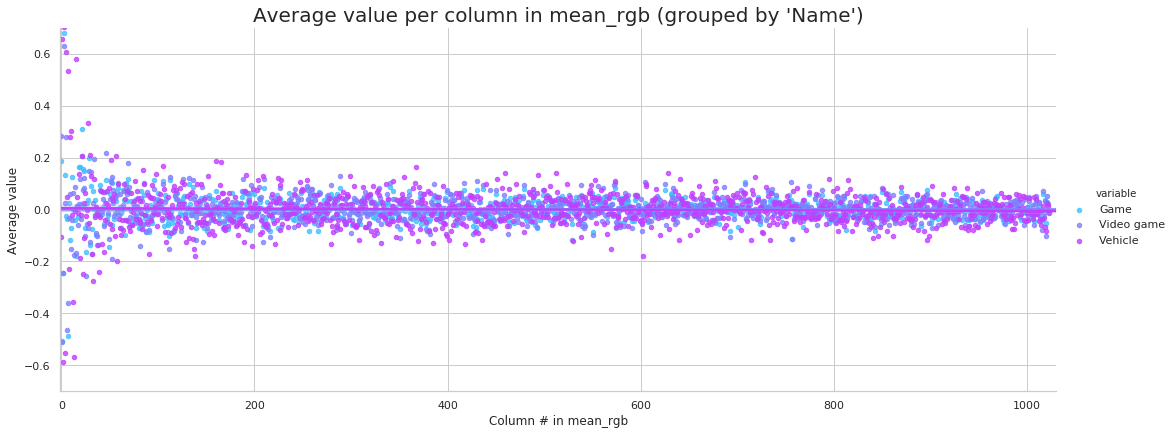

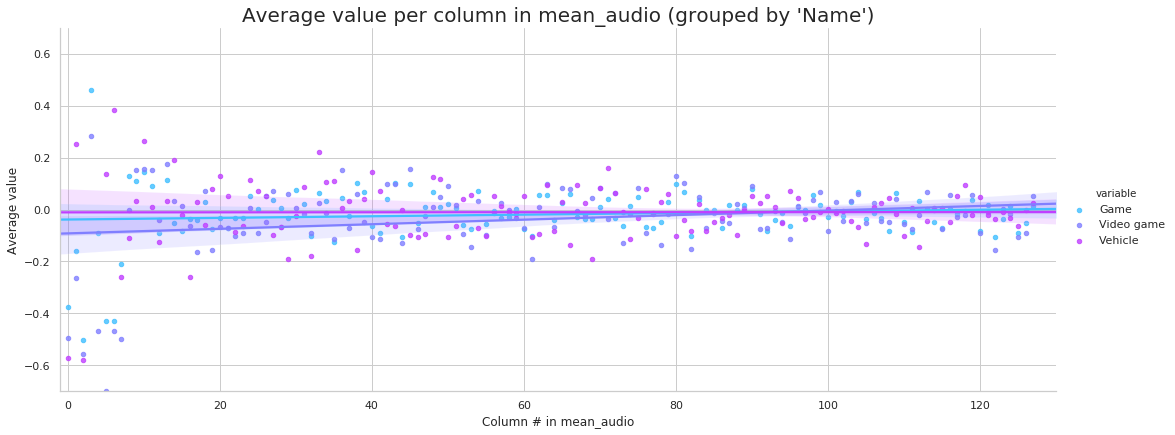

In [29]:
# assign indices to the top ten most common labels
top_indices = label_indices(v_labels, range(0,10))
explore_labels = ['index','Game','Video game','Vehicle']
params = {"x": "index", 
          "y": "value", 
          "hue": "variable",
          "height":6,
          "aspect":2.5, 
          "palette":color_choice, 
          "scatter_kws":dict(s=20, alpha=0.8)}

# create a df and visualize the the differences between three labels for mean_rgb

sub_df = df_transform_sns(v_mean_rgb,explore_labels)

sns.lmplot(**params,data=sub_df).set(xlim=(-1, 1030), ylim=(-.7,.7))
plt.title("Average value per column in mean_rgb (grouped by 'Name')",size=20)
plt.ylabel("Average value")
plt.xlabel('Column # in mean_rgb');

sub_df = df_transform_sns(v_mean_audio,explore_labels)
sns.lmplot(**params,data=sub_df).set(xlim=(-1, 130), ylim=(-.7,.7))
plt.title("Average value per column in mean_audio (grouped by 'Name')",size=20)
plt.ylabel("Average value")
plt.xlabel('Column # in mean_audio');

Both scatter plots show some interesting data. It appears that the mean average value of each label at the `N` feature level shows much more variability in the first 10% of features than in the last 90%. We should explore the samples (from different labels) from the first 10% of features to see how they relate and/or vary from one another

Now for the fun part. Let's do some statistical tests to determine whether or not the samples are genuinely different from one another. The first step is to decide which test is most relevant. Below is the chart I used to decide which test to use (NOTE: This chart has been simplified and doesn't fully account for more complex variable relationships, but is a good start for this project). We are working with continuous data and we want to see if two particular labels are different from one another. At present, I don't know if the data is normal, or skewed. We need to figure that out next.

<img src="http://i0.wp.com/slideplayer.com/6538273/23/images/6/Flow+chart+of+commonly+used+statistical+tests.jpg" alt="Statistical Chart" style="width: 500px;"/>

### **Visualize Sample Distributions for Top 3 Labels**

In [30]:
samples = {}
for lab in ['Game', 'Video game', 'Vehicle']:
    samples[lab] = ([[v_mean_rgb[i][u] for i in top_indices[lab]] for u in range(200)])

The hypothesis was that the first 10% of features hold more information than the remaining 90%. If that is true, we might also see differences in distributions of the top 3 labels in earlier features vs later features. Let's visualize the distribution of values for the top 3 labels for the first feature:


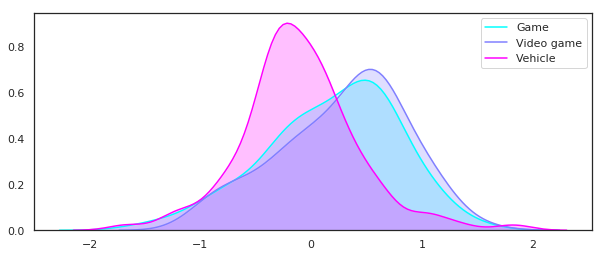

The samples 'Game' and 'Video game' have a p-value of 0.13972251305528083
The samples 'Game' and 'Vehicle' have a p-value of 2.213942021127611e-05


In [31]:
ind = 0
labels = ['Game', 'Video game', 'Vehicle']
visualize_data(samples,['Game', 'Video game', 'Vehicle'],ind)
t, p = scipy.stats.ttest_ind(samples['Game'][ind],samples['Video game'][ind])
print(f"The samples '{labels[0]}' and '{labels[1]}' have a p-value of {p}")
t, p = scipy.stats.ttest_ind(samples['Game'][ind],samples['Vehicle'][ind])
print(f"The samples '{labels[0]}' and '{labels[2]}' have a p-value of {p}")

Now let's visualize the sample distributions for the 200th feature in mean_rgb:

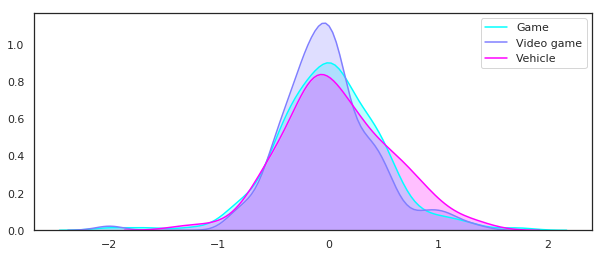

The samples 'Game' and 'Video game' have a p-value of 0.7069907101515897
The samples 'Game' and 'Vehicle' have a p-value of 0.2103139198902702


In [32]:
ind = 199
labels = ['Game', 'Video game', 'Vehicle']
visualize_data(samples,['Game', 'Video game', 'Vehicle'],ind)
t, p = scipy.stats.ttest_ind(samples['Game'][ind],samples['Video game'][ind])
print(f"The samples '{labels[0]}' and '{labels[1]}' have a p-value of {p}")
t, p = scipy.stats.ttest_ind(samples['Game'][ind],samples['Vehicle'][ind])
print(f"The samples '{labels[0]}' and '{labels[2]}' have a p-value of {p}")

As you can see from both the p value of the t-test and from the visual display of the data, it is much more apparent that there is a difference between the early variable and the later variable. Early variables appear to have an increased likelihood of being different samples, while later variables appear to have a much closer distribution shape.

<a id='s7'></a>

## 7. EDA Conclusion

The overall goal of this project was to learn about the data. We needed to better understand the data so that we can start using it in our model for the next step. In this project, we initially knew absolutely nothing about the YouTube data set, the competition, and the scoring metric. After finishing the project, we now know everything there is to know about the data files, YouTube's data set, data outliers, and possible models that might work for this type of project. We also strengthened our Google Alphabet domain knowledge a bit. We could now start building the model knowing that we now fully understand the data that is being pushed into the model.

**What we learned:**
1. The goal of the YouTube-8M data set is to create a model that makes predictions on a large data set (1.3 TB for the training set)
2. The ground truth (predicted feature) is the video labels.
3. The video labels are imbalanced and there is a large number of possible categorical values.
4. The ground truth can have a range of labels (i.e. not just one label), and models need to be able to predict a potential range of labels.
5. The features are continuous and appear to be both vectorized and normalized such that the original rgb/audio values are uknown
6. The example training data is in both CSV and TF form and each video sample is around a 2-5mb.
7. The mean value of early variables appear to hold more significant information than later variables
8. The mean_rgb values appear to be affected by videos that are stagnant (no visible change in the video) and/or by videos that have a majority of black or white color throughout the video.
9. Outliers in the sample data set can be found using T-SNE as well as from using inferential statistics. Depending on the model, removing outliers might improve the overall prediction rate of the model.

**Unanswered Questions:**
1. What is the purpose of the frame tfRecord file?
2. What do the `Vertical1`, `Vertical2`, `Vertical3` features represent?
3. What does the `KnowledgeGraphID` feature represent?
4. What changed with the data from between when the competition ended a year ago and now?

**Next Steps:**
1. Further check the hypothesis against more robust methods of feature analysis.
2. Build a model to check predictive accuracy of the first 50 mean_rgb features vs the last 50 mean_rgb features.
3. Use NMF and other feature reduction strategies to rank feature importance.
4. Build a CNN to output labels with predictions.
